In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np
import cv2
import os
import re
import pytesseract
from pytesseract import Output


from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#DIR_INPUT = "../input/my-receipts1/my_receipts"
DIR_INPUT = "../input/receipts-ola-uber/Ola_Uber_receipts"

In [3]:
train_df = pd.read_csv("../input/receipts-ola-uber/labels_receipts_OU.csv",header=None)
columns = ['class','xmin','ymin','w','h','image_id','ww','hh']
train_df.columns = columns
train_df.head()

,class,xmin,ymin,w,h,image_id,ww,hh
0,1,148,224,245,109,ola_1.jpg,540,960
1,1,460,115,158,91,ola_2.jpg,1080,1089
2,1,99,28,37,14,ola_3.jpg,237,213
3,1,78,24,30,15,ola_4.jpg,186,271
4,1,114,15,27,17,ola_5.jpg,259,194


In [4]:
#train_df = pd.read_csv("../input/receipts-labels/labels_receipts16.csv",header=None)
#columns = ['class','xmin','ymin','w','h','image_id','ww','hh']
#train_df.columns = columns
#train_df.head()

In [5]:
#train_df1 = pd.read_csv("../input/receipts-labels196/labels_receipts196.csv",header=None)
#columns = ['class','xmin','ymin','w','h','image_id','ww','hh']
#train_df1.columns = columns
#train_df1.head()

In [6]:
#train_df = pd.concat([train_df,train_df1])

In [7]:
#train_df.shape
#image_ids = len(train_df['image_id'].unique())


#train_df.drop_duplicates(subset='image_id',keep="first",inplace=True)

In [8]:
image_ids = train_df['image_id'].unique()
valid_ids = image_ids[[5,12]]
train_ids = image_ids[[0,1,2,3,4,7,8,9,10,11]]
test_ids = image_ids[[6,13]]

test_df = train_df[train_df['image_id'].isin(test_ids)]
valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

In [9]:
class CABDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['xmin', 'ymin', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [10]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [11]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [12]:
num_classes = 2  

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [13]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [14]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = CABDataset(train_df, DIR_INPUT, get_train_transform())
valid_dataset = CABDataset(valid_df, DIR_INPUT, get_valid_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

In [15]:
train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=1,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=1,
    collate_fn=collate_fn
)

In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [17]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 6

In [18]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")

Epoch #0 loss: 0.5816956066414516
Epoch #1 loss: 0.19558724187740797
Epoch #2 loss: 0.2700053716241423
Epoch #3 loss: 0.24319531103899156
Epoch #4 loss: 0.26509835906605417
Epoch #5 loss: 0.227598883215411


In [19]:
images, targets, image_ids = next(iter(valid_data_loader))

In [20]:
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [21]:
boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
sample = images[0].permute(1,2,0).cpu().numpy()

In [22]:
model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

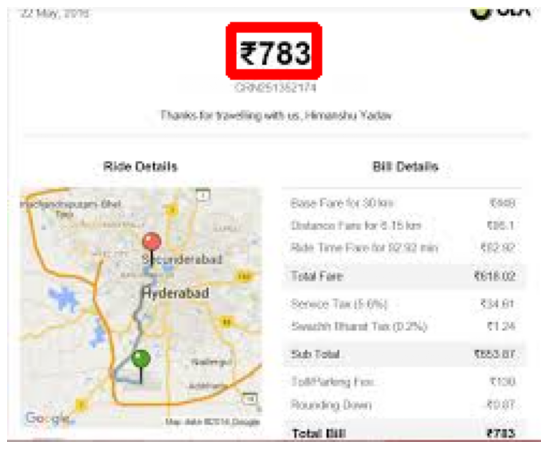

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

In [24]:
test_df.head()
test_df = test_df.drop(columns=['class','xmin','ymin','w','h','ww','hh'],axis=1)

In [25]:
class CABTestDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [26]:
# Albumentations
def get_test_transform():
    return A.Compose([
        # A.Resize(512, 512),
        ToTensorV2(p=1.0)
    ])

In [27]:
def collate_fn(batch):
    return tuple(zip(*batch))

test_dataset = CABTestDataset(test_df, DIR_INPUT, get_test_transform())

test_data_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

In [28]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

In [29]:
def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))


In [30]:
# text detection
def contours_text(orig, boxes):
    for box in boxes:
        #x, y, w, h = cv2.boundingRect(cnt) 
        x,y,w,h = box[0],box[1],box[2],box[3]
        # Drawing a rectangle on copied image 
        rect = cv2.rectangle(orig, (x, y), (x+w, y+h), (0, 255, 255), 2) 
        #print(x,y,w,h)
        #cv2.imshow('cnt',rect)
        #cv2.waitKey()

        # Cropping the text block for giving input to OCR 
        cropped = orig[y:y+h, x:x+w] 
        #cv2.imshow(cropped)
        # Apply OCR on the cropped image 
        config = ('-l eng --oem 3 --psm 6')
        text = pytesseract.image_to_string(cropped, config=config) 

        print(text)

In [31]:
#file_name = "../input/my-receipts1/my_receipts/1187-receipt.jpg"

#image = cv2.imread(file_name)

#bx1 = [[731,753,133,71]]
#contours_text(image,bx1)

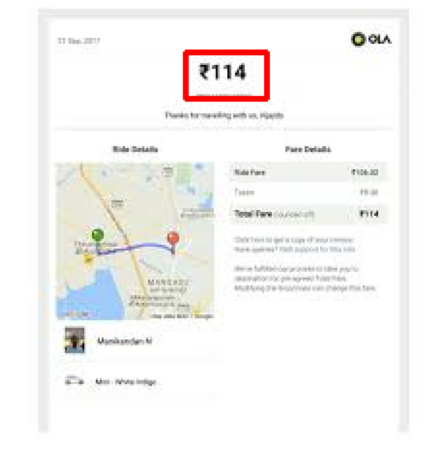

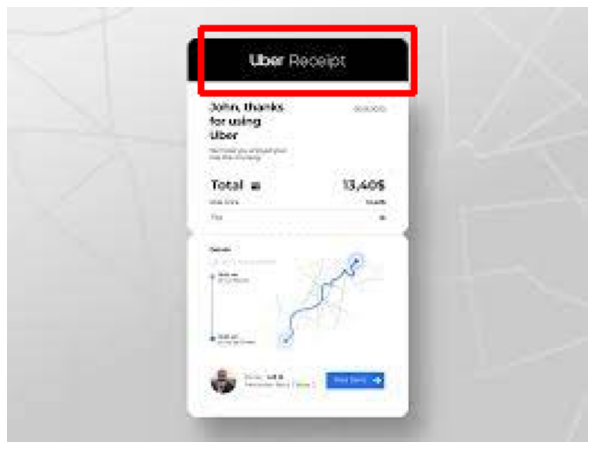

In [32]:
detection_threshold = 0.2
results = []
final_result = []
for images, image_ids in test_data_loader:

    images = list(image.to(device) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }

        
        results.append(result)
        
        sample = images[i].permute(1,2,0).cpu().numpy()
        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        if len(scores)>0 :
            max_score = scores.max()
        else:
            max_score = 0.0
        #boxes = boxes[scores >= detection_threshold].astype(np.int32)
        boxes = boxes[scores >= max_score].astype(np.int32)
        
        #file_name = f"../input/my-receipts1/my_receipts/{image_id}"
        #img_new = cv2.imread(file_name)      
        #contours_text(img_new, boxes)
        
        fig, ax = plt.subplots(1, 1, figsize=(16, 8))

        for box in boxes:
            cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 2)
            final_result.append([image_id,box[0], box[1],box[2], box[3]])

        ax.set_axis_off()
        ax.imshow(sample)

In [33]:
for box in final_result:
    #total_box = []
    file_name = f"../input/receipts-ola-uber/Ola_Uber_receipts/{box[0]}"
    total_box = [[box[1],box[2],box[3],box[4]]]
    print(file_name)
    #print(total_box)
    img_new = cv2.imread(file_name)
    contours_text(img_new,total_box)
    

../input/receipts-ola-uber/Ola_Uber_receipts/ola_7.jpg
a4

../input/receipts-ola-uber/Ola_Uber_receipts/Uber_7.jpg

